# Implementação de Grafos Em Python

### Alunos: Jean Reinhold, Rafael Mews Boeira, Rodrigo Barbosa

## Importação e instação de dependências



In [1]:
%%capture
!pip install faker
!pip install pydantic --upgrade
!pip install bidict

from bidict import bidict

from typing import Dict, Any
from pydantic import BaseModel
from typing import Type, List, Protocol

from faker import Faker
import random

from google.colab import widgets
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

## Definições de grafo, vértice e verticiável 



In [2]:
class Vertexiable(Protocol):
    """
    Definição de um procolo que define a inteface para
    um tipo de dado que será armazenado em um vértice.
    """

    def __hash__(self):
        pass

    def representation(self):
        pass


class Person(BaseModel):
    """
    Classe que representa uma pessoa. O intuito dela é
    puramente ter uma aplicação mais clara para os grafos,
    que neste caso representam uma rede de contatos.
    """

    name: str
    email: str
    age: int
    phone: str

    def __hash__(self):
        """
        Função que garante que uma pessoa seja única no nosso grafo
        """
        return hash(self.email)

    def representation(self):
        return self.name


class SimplifiedPerson(BaseModel):
    """
    Classe que representa o vértice mais simples possível
    """

    name: str

    def __hash__(self):
        return hash(self.name)

    def representation(self):
        return self.name


def create_people(num_people: int) -> List[Person]:
    """
    Função de seed parametrizável para gerar novas pessoas na rede
    """
    fake = Faker()
    people = []
    for _ in range(num_people):
        person = Person(
            name=fake.first_name(),
            email=fake.email(),
            age=fake.random_int(min=18, max=100, step=1),
            phone=fake.phone_number(),
        )
        people.append(person)
    return people


class Vertex(BaseModel):
    """
    Classe de um vértice, o tipo de dado é abstraído dentro
    de um atributo 'data'.

    A utilização de sets para armazenamento de vértices adjascentes
    é para garantir tempo de busca constante

    O tipo Type["nome da classe"] é uma técnica de referencia adiantada.
    Ela permite referenciar o tipo da própria classe
    """

    data: Any
    adjacent: Dict = dict()

    def add_adjascent(self, vertex: Type["Vertex"], weight: int):
        self.adjacent[vertex] = weight

    def remove_adjacent(self, vertex: Type["Vertex"]):
        self.adjacent.pop(vertex)

    def is_adjacent(self, vertex: Type["Vertex"]):
        return vertex in self.adjacent

    def get_adjacent(self):
        return self.adjacent

    def __hash__(self):
        return self.data.__hash__()

    def representation(self):
        return self.data.representation()


class Graph(BaseModel):
    vertices: set = set()
    max_vertices: int = 20

    def add_vertex(self, vertex: Vertex):
        if len(self.vertices) == self.max_vertices:
            raise OverflowError("Too many vertices, wont include a new one")

        self.vertices.add(vertex)

    def remove_vertex(self, to_remove_vertex: Vertex):
        if to_remove_vertex not in self.vertices:
            raise ValueError("Vertex not found")

        self.vertices.remove(to_remove_vertex)
        for vertex in self.vertices:
            vertex.remove_adjacent(to_remove_vertex)

    def add_edge(self, a: Vertex, b: Vertex, weight: int):
        if a not in self.vertices or b not in self.vertices:
            raise ValueError("Vertex not found")

        a.add_adjascent(b, weight)
        b.add_adjascent(a, weight)

    def remove_edge(self, a: Vertex, b: Vertex):
        if a not in self.vertices or b not in self.vertices:
            raise ValueError("Vertex not found")

        a.remove_adjascent(b)
        b.remove_adjascent(a)

    def is_adjacent(self, a: Vertex, b: Vertex):
        if a not in self.vertices or b not in self.vertices:
            raise ValueError("Vertex not found")

        return a.is_adjascent(b)

    def contains(self, vertex: Vertex):
        return vertex in self.vertices

    def get_vertices(self):
        return self.vertices

    def get_edges(self) -> set():
        vertices = self.get_vertices()
        edges = {frozenset((vertex, adj)) for vertex in vertices for adj in vertex.get_adjacent()}
        return edges

    def plot(self):
        """
        Utiliza uma lib de grafos para plotar nossa implementação hahah,
        nós convertemos um grafo em outro tipo e por isso conseguimos fazer isso.
        """
        graph = nx.Graph()
        for vertex in self.get_vertices():
            graph.add_node(vertex.representation())

        for vertex in self.get_vertices():
            for adjascent, weight in vertex.get_adjacent().items():
                graph.add_edge(
                    vertex.representation(), adjascent.representation(), weight=weight
                )
        pos = nx.random_layout(graph)
        edges = graph.edges()
        weights = [graph[u][v]["weight"] for u, v in edges]
        nx.draw(
            graph,
            pos,
            with_labels=True,
            edge_color="red",
            width=weights,
            node_size=3000,
        )


def read_df_from_google_sheets(url: str) -> pd.DataFrame:
    url = url.replace("/edit#gid=", "/export?format=csv&gid=")
    return pd.read_csv(url).fillna(0)


def get_adjacency_matrix_from_google_sheets(url: str) -> np.array:
    sheet = read_df_from_google_sheets(url)

    col_names = sheet.columns.values
    return np.vstack([col_names, sheet.to_numpy()])


def get_name_map_from_adjacency_matrix(adjacency_matrix: np.array) -> dict:
    return {i + 1: name for i, name in enumerate(adjacency_matrix[1:, 0])}


def get_edges_from_adjacency_matrix(adjacency_matrix: np.array) -> set:
    """
    Função que encontra todas as arestas existentes entre os vértices
    """
    name_map = get_name_map_from_adjacency_matrix(adjacency_matrix)

    edges = set()
    for pair in zip(*np.where(adjacency_matrix[1:, 1:].astype(int) > 0)):
        ordered_pair = sorted(pair)

        ordered_pair = map(lambda x: name_map[x + 1], ordered_pair)
        edges.add(tuple(ordered_pair))

    return edges


##  Criação de um grafo a partir de uma seed parametrizável

###*Obs.: a espessura das ligações é proporcional ao peso das arestas*


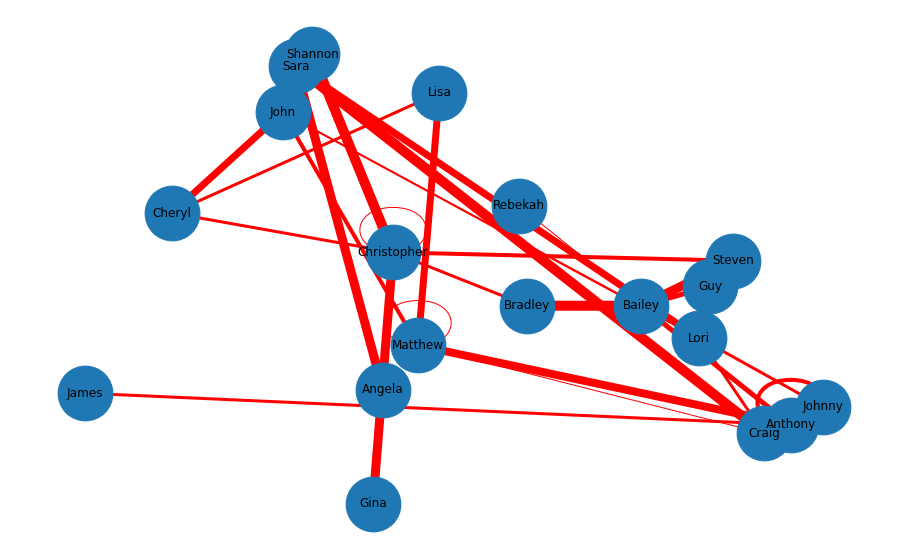

In [3]:
N_PEOPLE: int = 20
GRAPH_CONNECTIONS: int = 30

social_network = Graph()

vertices = []
for person in create_people(N_PEOPLE):
    vertex = Vertex(data=person)
    social_network.add_vertex(vertex)

    vertices.append(vertex)

for _ in range(GRAPH_CONNECTIONS):
    index_a, index_b = random.choices(range(N_PEOPLE), k=2)

    a = vertices[index_a]
    b = vertices[index_b]
    social_network.add_edge(a, b, weight=random.randint(1, 10))


fig, ax = plt.subplots(figsize=(16, 10))
social_network.plot()
plt.show()

## Criação do grafo a partir de uma matriz de adjascência no google sheets: 

Para editar a matriz e criar um novo grafo, entre neste [link](https://docs.google.com/spreadsheets/d/11rUFD4bh81mYtqmE3mK8aAvxsCmQ98hLKtLTEHn0v8Q/edit#gid=0) para editar o sheets e então rode as células novamente.

In [4]:
SHEET_URL = "https://docs.google.com/spreadsheets/d/11rUFD4bh81mYtqmE3mK8aAvxsCmQ98hLKtLTEHn0v8Q/edit#gid=0"

read_df_from_google_sheets(SHEET_URL)

,Person,Rafael,Jean,Rodrigo,Guilherme,Theago,Maria,José,Ítalo,Roberta,...,Ana,Carl,Charles,Pedro,Juvenal,Mohamed,Joana,Carla,Annita,Shakira
0,Rafael,0.0,4.0,1.0,5.0,6.0,1.0,1.0,0.0,7.0,...,5.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
1,Jean,4.0,0.0,0.0,4.0,9.0,0.0,4.0,2.0,0.0,...,5.0,0.0,2.0,4.0,0.0,0.0,7.0,0.0,8.0,0.0
2,Rodrigo,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0
3,Guilherme,5.0,4.0,0.0,0.0,5.0,1.0,5.0,6.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Theago,6.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Maria,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,José,1.0,4.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
7,Ítalo,0.0,2.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Roberta,7.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Eduardo,1.0,4.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Tradução da matriz de adjascência para um grafo da nossa implementação



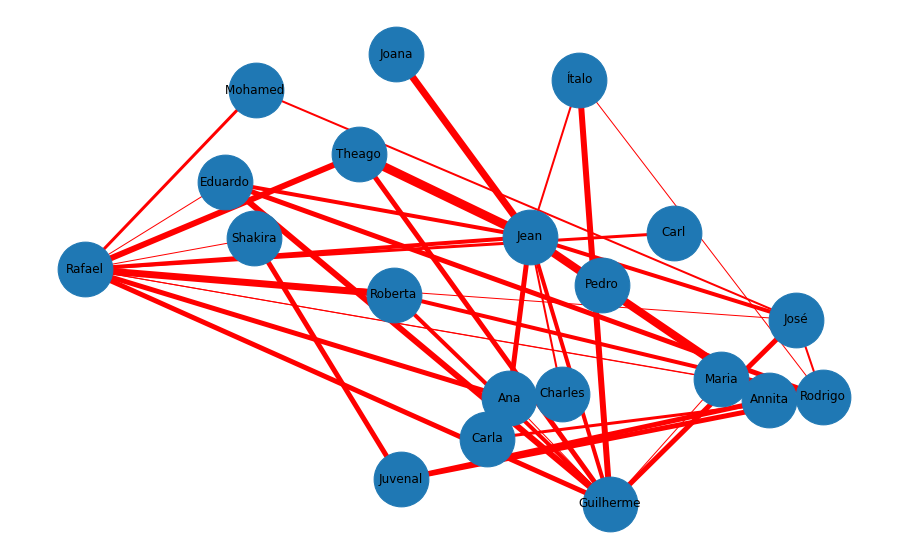

In [5]:
social_network = Graph()

adjacency_matrix = get_adjacency_matrix_from_google_sheets(SHEET_URL)
edges = get_edges_from_adjacency_matrix(adjacency_matrix)
name_map = get_name_map_from_adjacency_matrix(adjacency_matrix) 

vertices = bidict()
for name in name_map.values():
    person = SimplifiedPerson(name=name)
    vertex = Vertex(data=person)
    social_network.add_vertex(vertex)

    vertices[name] = vertex

name_map = bidict(name_map)
for name_a, name_b in edges:
    row, col = name_map.inverse[name_a], name_map.inverse[name_b]
    social_network.add_edge(
        vertices[name_a],
        vertices[name_b],
        weight=(adjacency_matrix[row, col])
    )


fig, ax = plt.subplots(figsize=(16, 10))
social_network.plot()
plt.show()